# Домашнее задание 2. Классификация изображений.

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.
 
__Задание__. Необходимо выполнить любое из двух заданий

1) Добейтесь accuracy **на валидации не менее 0.44**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 

2) Добейтесь accuracy **на валидации не менее 0.84**. В этом задании делать ресайз и использовать претрейн можно. 

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете. 

Ваш код обязательно должен проходить все `assert`'ы ниже.

Необходимо написать функции `train_one_epoch`, `train` и `predict` по шаблонам ниже (во многом повторяют примеры с семинаров).Обратите особое внимание на функцию `predict`: она должна возвращать список лоссов по всем объектам даталоадера, список предсказанных классов для каждого объекта из даталоалера и список настоящих классов для каждого объекта в даталоадере (и именно в таком порядке).

__Использовать внешние данные для обучения строго запрещено в обоих заданиях. Также запрещено обучаться на валидационной выборке__.


__Критерии оценки__: Оценка вычисляется по простой формуле: `min(10, 10 * Ваша accuracy / 0.44)` для первого задания и `min(10, 10 * (Ваша accuracy - 0.5) / 0.34)` для второго. Оценка округляется до десятых по арифметическим правилам. Если вы выполнили оба задания, то берется максимум из двух оценок.

__Бонус__. Вы получаете 5 бонусных баллов если справляетесь с обоими заданиями на 10 баллов (итого 15 баллов). В противном случае выставляется максимальная из двух оценок и ваш бонус равен нулю.

__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Используйте аугментации. Для этого пользуйтесь модулем `torchvision.transforms` или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - Можно обучать с нуля или файнтюнить (в зависимости от задания) модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом `ImageFolder`), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.
 
Good luck & have fun! :)

In [ ]:
import numpy as np
import torch
import torchvision
import tqdm
from torch import nn
from torch.nn import functional as F
from sklearn.metrics import accuracy_score
from torchvision.datasets import ImageFolder

# You may add any imports you need
from torch import optim
from torchvision import datasets, transforms
from torchvision.transforms import Compose, Normalize, Resize, ToTensor 
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.models import resnet18
from google.colab import files
from tqdm.auto import tqdm
import random
import sys
import matplotlib.pyplot as plt

**В данном решении были исползованы функции и фрагменты кода из 3его и 5ого семинаров, а также с сайтов:**
# https://www.machinelearningmastery.ru/how-to-train-an-image-classifier-in-pytorch-and-use-it-to-perform-basic-inference-on-single-images-99465a1e9bf5/
# https://medium.com/secure-and-private-ai-writing-challenge/loading-image-using-pytorch-c2e2dcce6ef2
# https://alexanderkurakin.blogspot.com/2018/12/pytorch-image-classifier.html

In [ ]:
# скачиваем
!wget https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip

--2021-11-18 17:36:06--  https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.68.18, 2620:100:6020:18::a27d:4012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.68.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/33l8lp62rmvtx40/dataset.zip [following]
--2021-11-18 17:36:06--  https://www.dropbox.com/s/raw/33l8lp62rmvtx40/dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce1ab0beb8434178feb6e01dec5.dl.dropboxusercontent.com/cd/0/inline/BaMKBjKEHo1wkkmMG8mFWXoEVJb_YHBlSi8yT_zH53zGfnXeEwgok4h_3X1kakRrD0xbIJquku7trvwVTDcovkZ-I3ZW0KVeQBKb5uptJK6vhmycCmQIjoMSflW8yZ2aTZ89Ix2lwHW9J_v9JuLKe0ME/file# [following]
--2021-11-18 17:36:07--  https://uce1ab0beb8434178feb6e01dec5.dl.dropboxusercontent.com/cd/0/inline/BaMKBjKEHo1wkkmMG8mFWXoEVJb_YHBlSi8yT_zH53zGfnXeEwgok4h_3X1kakRrD0xbIJquku7trvwVTDcovkZ-I3

In [ ]:
# распаковываем
!unzip dataset.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: dataset/dataset/val/class_101/00048.jpg  
  inflating: dataset/dataset/val/class_101/00049.jpg  
   creating: dataset/dataset/val/class_102/
  inflating: dataset/dataset/val/class_102/00000.jpg  
  inflating: dataset/dataset/val/class_102/00001.jpg  
  inflating: dataset/dataset/val/class_102/00002.jpg  
  inflating: dataset/dataset/val/class_102/00003.jpg  
  inflating: dataset/dataset/val/class_102/00004.jpg  
  inflating: dataset/dataset/val/class_102/00005.jpg  
  inflating: dataset/dataset/val/class_102/00006.jpg  
  inflating: dataset/dataset/val/class_102/00007.jpg  
  inflating: dataset/dataset/val/class_102/00008.jpg  
  inflating: dataset/dataset/val/class_102/00009.jpg  
  inflating: dataset/dataset/val/class_102/00010.jpg  
  inflating: dataset/dataset/val/class_102/00011.jpg  
  inflating: dataset/dataset/val/class_102/00012.jpg  
  inflating: dataset/dataset/val/class_102/00013.jpg  
  inflat

In [ ]:
%ls

dataset/  dataset.zip  sample_data/


In [ ]:
# функция фиксации seed для random (из первого дз)
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [ ]:
# класс датасета
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform):
        set_random_seed(192)
        self.data_dir = data_dir
        self.transform = transform
        self.dataset = ImageFolder(
                          self.data_dir, 
                          transform=self.transform
                          )
        self.len_of_dataset = len(self.dataset)

    
    def __getitem__(self, idx):
        return self.dataset[idx]

    
    def __len__(self):
        return self.len_of_dataset

In [ ]:
# функция показа нескольких изображений датасета
def imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [ ]:
set_random_seed(192)
BATCH_SIZE = 128
# transform и аугментации
train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        #transforms.ColorJitter(hue=.05, saturation=.05),
        #transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
        transforms.RandomResizedCrop(64),
        transforms.RandomHorizontalFlip(0.5),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
val_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_dataset = MyDataset("dataset/dataset/train", transform=train_transform)
val_dataset = MyDataset("dataset/dataset/val", transform=val_transform)

indices_train = list(range(train_dataset.len_of_dataset))
train_sampler = SubsetRandomSampler(indices_train)

indices_val = list(range(val_dataset.len_of_dataset))
val_sampler = SubsetRandomSampler(indices_val)

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                   sampler=train_sampler, batch_size=BATCH_SIZE)
val_dataloader = torch.utils.data.DataLoader(val_dataset,
                   sampler=val_sampler, batch_size=BATCH_SIZE)

tensor(15) tensor(165) tensor(90) tensor(4) tensor(98)
torch.Size([128, 3, 64, 64])
Labels_train:  tensor([ 15, 165,  90,   4,  98])


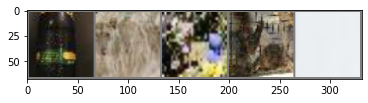

In [ ]:
n = 5
images1, labels1 = next(iter(train_dataloader))
imshow(torchvision.utils.make_grid(images1[:n]))
print(' '.join('%5s' % labels1[j] for j in range(n)))
print(images1.shape)
print("Labels_train: ", labels1[:n])

tensor(105) tensor(195) tensor(85) tensor(65) tensor(141)
torch.Size([128, 3, 64, 64])
Labels_val:  tensor([105, 195,  85,  65, 141])


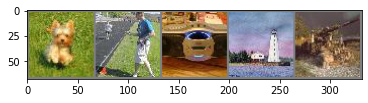

In [ ]:
images2, labels2 = next(iter(val_dataloader))
imshow(torchvision.utils.make_grid(images2[:n]))
print(' '.join('%5s' % labels2[j] for j in range(n)))
print(images2.shape)
print("Labels_val: ", labels2[:n])

In [ ]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
set_random_seed(192)
model = resnet18(pretrained=False)
model.fc = nn.Linear(512, 200)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], gamma=0.6)

Функции из 5 семинара

In [ ]:
def train_epoch(model, data_loader, optimizer, criterion, device, return_losses=False, scheduler = None):
  model = model.to(device).train()
  total_loss = 0
  num_batches = 0
  all_losses = []
  total_predictions = np.array([])#.reshape((0, ))
  total_labels = np.array([])#.reshape((0, ))
  with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
      for images, labels in data_loader:
          # Move Batch to GPU
          images = images.to(device)
          labels = labels.to(device)
          predicted = model(images)
          loss = criterion(predicted, labels)
          # Update weights
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
          # Update descirption for tqdm
          accuracy = (predicted.argmax(1) == labels).float().mean()
          prbar.set_description(
              f"Loss: {round(loss.item(), 4)} "
              f"Accuracy: {round(accuracy.item() * 100, 4)}"
          )
          prbar.update(1)
          total_loss += loss.item()
          total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
          total_labels = np.append(total_labels, labels.cpu().detach().numpy())
          num_batches += 1
          all_losses.append(loss.detach().item())
  metrics = {"loss": total_loss / num_batches}
  metrics.update({"Current epoch accuracy": (total_predictions == total_labels).mean()})
  scheduler.step()
  print("Current epoch accuracy", (total_predictions == total_labels).mean())
  if return_losses:
      return metrics, all_losses
  else:
      return metrics

In [ ]:
def predict(model, data_loader, criterion, device):
    model = model.eval()
    loss_summary = []
    total_loss = 0
    num_batches = 0
    total_predictions = np.array([])
    total_labels = np.array([])
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            predicted = model(images)
            loss = criterion(predicted, labels)
            accuracy = (predicted.argmax(1) == labels).float().mean()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            loss_summary.append(loss.item())
            total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
    metrics = {"loss": total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    print("TEST ACCURACY: ", metrics)
    return loss_summary, total_predictions, total_labels

In [ ]:
def fit(model, epochs, train_data_loader, validation_data_loader, optimizer, criterion, device, scheduler=None):
    set_random_seed(192)
    all_train_losses = []
    epoch_train_losses = []
    #epoch_eval_losses = []
    for epoch in range(epochs):
        # Train step
        print(f"Train Epoch: {epoch}")
        train_metrics, one_epoch_train_losses = train_epoch(
            model=model,
            data_loader=train_data_loader,
            optimizer=optimizer,
            return_losses=True,
            criterion=criterion,
            device=device,
            scheduler=scheduler
        )
        # Save Train losses
        all_train_losses.extend(one_epoch_train_losses)
        epoch_train_losses.append(train_metrics["loss"])
        # Eval step
        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            validation_metrics, total_predictions, total_labels = predict(
                model=model,
                data_loader=validation_data_loader,
                criterion=criterion,
                device=device
            )
        val_metrics = (total_predictions == total_labels).mean()
        # Save eval losses
        epoch_eval_losses = validation_metrics
    return val_metrics, epoch_eval_losses

In [ ]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(predicted_labels, true_labels)
print("tests passed")

  0%|          | 0/79 [00:00<?, ?it/s]

TEST ACCURACY:  {'loss': 5.340418513817124, 'accuracy': 0.0045}
tests passed


In [ ]:
set_random_seed(192)
final_val_metrics, valid_losses = fit(model, 30, train_dataloader, val_dataloader, optimizer, criterion, device=device, scheduler=scheduler)

Train Epoch: 0


  0%|          | 0/782 [00:00<?, ?it/s]

Current epoch accuracy 0.05987
Validation Epoch: 0


  0%|          | 0/79 [00:00<?, ?it/s]

TEST ACCURACY:  {'loss': 4.4277119696894776, 'accuracy': 0.0837}
Train Epoch: 1


  0%|          | 0/782 [00:00<?, ?it/s]

Current epoch accuracy 0.12318
Validation Epoch: 1


  0%|          | 0/79 [00:00<?, ?it/s]

TEST ACCURACY:  {'loss': 3.8503842625436904, 'accuracy': 0.1556}
Train Epoch: 2


  0%|          | 0/782 [00:00<?, ?it/s]

Current epoch accuracy 0.16487
Validation Epoch: 2


  0%|          | 0/79 [00:00<?, ?it/s]

TEST ACCURACY:  {'loss': 3.5181273387957224, 'accuracy': 0.2047}
Train Epoch: 3


  0%|          | 0/782 [00:00<?, ?it/s]

Current epoch accuracy 0.20039
Validation Epoch: 3


  0%|          | 0/79 [00:00<?, ?it/s]

TEST ACCURACY:  {'loss': 3.3321307973016667, 'accuracy': 0.2435}
Train Epoch: 4


  0%|          | 0/782 [00:00<?, ?it/s]

Current epoch accuracy 0.22835
Validation Epoch: 4


  0%|          | 0/79 [00:00<?, ?it/s]

TEST ACCURACY:  {'loss': 3.261706180210355, 'accuracy': 0.257}
Train Epoch: 5


  0%|          | 0/782 [00:00<?, ?it/s]

Current epoch accuracy 0.25366
Validation Epoch: 5


  0%|          | 0/79 [00:00<?, ?it/s]

TEST ACCURACY:  {'loss': 3.1641612596149686, 'accuracy': 0.2777}
Train Epoch: 6


  0%|          | 0/782 [00:00<?, ?it/s]

Current epoch accuracy 0.27515
Validation Epoch: 6


  0%|          | 0/79 [00:00<?, ?it/s]

TEST ACCURACY:  {'loss': 3.1848989679843567, 'accuracy': 0.2792}
Train Epoch: 7


  0%|          | 0/782 [00:00<?, ?it/s]

Current epoch accuracy 0.29188
Validation Epoch: 7


  0%|          | 0/79 [00:00<?, ?it/s]

TEST ACCURACY:  {'loss': 3.0122104023076313, 'accuracy': 0.3128}
Train Epoch: 8


  0%|          | 0/782 [00:00<?, ?it/s]

Current epoch accuracy 0.30971
Validation Epoch: 8


  0%|          | 0/79 [00:00<?, ?it/s]

TEST ACCURACY:  {'loss': 3.0312732956077477, 'accuracy': 0.3104}
Train Epoch: 9


  0%|          | 0/782 [00:00<?, ?it/s]

Current epoch accuracy 0.32462
Validation Epoch: 9


  0%|          | 0/79 [00:00<?, ?it/s]

TEST ACCURACY:  {'loss': 2.9327472553977483, 'accuracy': 0.3296}
Train Epoch: 10


  0%|          | 0/782 [00:00<?, ?it/s]

Current epoch accuracy 0.33779
Validation Epoch: 10


  0%|          | 0/79 [00:00<?, ?it/s]

TEST ACCURACY:  {'loss': 2.9506300038929227, 'accuracy': 0.3427}
Train Epoch: 11


  0%|          | 0/782 [00:00<?, ?it/s]

Current epoch accuracy 0.35341
Validation Epoch: 11


  0%|          | 0/79 [00:00<?, ?it/s]

TEST ACCURACY:  {'loss': 2.765792834607861, 'accuracy': 0.3595}
Train Epoch: 12


  0%|          | 0/782 [00:00<?, ?it/s]

Current epoch accuracy 0.36499
Validation Epoch: 12


  0%|          | 0/79 [00:00<?, ?it/s]

TEST ACCURACY:  {'loss': 2.7245248465598384, 'accuracy': 0.3688}
Train Epoch: 13


  0%|          | 0/782 [00:00<?, ?it/s]

Current epoch accuracy 0.37844
Validation Epoch: 13


  0%|          | 0/79 [00:00<?, ?it/s]

TEST ACCURACY:  {'loss': 2.6431689745263207, 'accuracy': 0.3833}
Train Epoch: 14


  0%|          | 0/782 [00:00<?, ?it/s]

Current epoch accuracy 0.38539
Validation Epoch: 14


  0%|          | 0/79 [00:00<?, ?it/s]

TEST ACCURACY:  {'loss': 2.69652538058124, 'accuracy': 0.3836}
Train Epoch: 15


  0%|          | 0/782 [00:00<?, ?it/s]

Current epoch accuracy 0.39906
Validation Epoch: 15


  0%|          | 0/79 [00:00<?, ?it/s]

TEST ACCURACY:  {'loss': 2.638630034048346, 'accuracy': 0.393}
Train Epoch: 16


  0%|          | 0/782 [00:00<?, ?it/s]

Current epoch accuracy 0.4085
Validation Epoch: 16


  0%|          | 0/79 [00:00<?, ?it/s]

TEST ACCURACY:  {'loss': 2.6531705041474933, 'accuracy': 0.3895}
Train Epoch: 17


  0%|          | 0/782 [00:00<?, ?it/s]

Current epoch accuracy 0.44166
Validation Epoch: 17


  0%|          | 0/79 [00:00<?, ?it/s]

TEST ACCURACY:  {'loss': 2.5413378552545476, 'accuracy': 0.415}
Train Epoch: 18


  0%|          | 0/782 [00:00<?, ?it/s]

Current epoch accuracy 0.46674
Validation Epoch: 18


  0%|          | 0/79 [00:00<?, ?it/s]

TEST ACCURACY:  {'loss': 2.503121787988687, 'accuracy': 0.4274}
Train Epoch: 19


  0%|          | 0/782 [00:00<?, ?it/s]

Current epoch accuracy 0.48747
Validation Epoch: 19


  0%|          | 0/79 [00:00<?, ?it/s]

TEST ACCURACY:  {'loss': 2.4818876951555664, 'accuracy': 0.4325}
Train Epoch: 20


  0%|          | 0/782 [00:00<?, ?it/s]

Current epoch accuracy 0.49903
Validation Epoch: 20


  0%|          | 0/79 [00:00<?, ?it/s]

TEST ACCURACY:  {'loss': 2.470204160183291, 'accuracy': 0.4367}
Train Epoch: 21


  0%|          | 0/782 [00:00<?, ?it/s]

Current epoch accuracy 0.51068
Validation Epoch: 21


  0%|          | 0/79 [00:00<?, ?it/s]

TEST ACCURACY:  {'loss': 2.4567078834847558, 'accuracy': 0.4393}
Train Epoch: 22


  0%|          | 0/782 [00:00<?, ?it/s]

Current epoch accuracy 0.51247
Validation Epoch: 22


  0%|          | 0/79 [00:00<?, ?it/s]

TEST ACCURACY:  {'loss': 2.4542292009426068, 'accuracy': 0.4416}
Train Epoch: 23


  0%|          | 0/782 [00:00<?, ?it/s]

Current epoch accuracy 0.51746
Validation Epoch: 23


  0%|          | 0/79 [00:00<?, ?it/s]

TEST ACCURACY:  {'loss': 2.4594908696186693, 'accuracy': 0.4434}
Train Epoch: 24


  0%|          | 0/782 [00:00<?, ?it/s]

Current epoch accuracy 0.5183
Validation Epoch: 24


  0%|          | 0/79 [00:00<?, ?it/s]

TEST ACCURACY:  {'loss': 2.465911005116716, 'accuracy': 0.4415}
Train Epoch: 25


  0%|          | 0/782 [00:00<?, ?it/s]

Current epoch accuracy 0.51803
Validation Epoch: 25


  0%|          | 0/79 [00:00<?, ?it/s]

TEST ACCURACY:  {'loss': 2.4743835729888723, 'accuracy': 0.438}
Train Epoch: 26


  0%|          | 0/782 [00:00<?, ?it/s]

Current epoch accuracy 0.51965
Validation Epoch: 26


  0%|          | 0/79 [00:00<?, ?it/s]

TEST ACCURACY:  {'loss': 2.4787634233885174, 'accuracy': 0.4369}
Train Epoch: 27


  0%|          | 0/782 [00:00<?, ?it/s]

Current epoch accuracy 0.52394
Validation Epoch: 27


  0%|          | 0/79 [00:00<?, ?it/s]

TEST ACCURACY:  {'loss': 2.449336969399754, 'accuracy': 0.4411}
Train Epoch: 28


  0%|          | 0/782 [00:00<?, ?it/s]

Current epoch accuracy 0.52029
Validation Epoch: 28


  0%|          | 0/79 [00:00<?, ?it/s]

TEST ACCURACY:  {'loss': 2.4556440673296964, 'accuracy': 0.44}
Train Epoch: 29


  0%|          | 0/782 [00:00<?, ?it/s]

Current epoch accuracy 0.52186
Validation Epoch: 29


  0%|          | 0/79 [00:00<?, ?it/s]

TEST ACCURACY:  {'loss': 2.4391139987148818, 'accuracy': 0.4419}


Как можно заметить по динамике обучения выше, необходимая точность достигается уже на 26ой эпохе. Таким образом, брать 30 эпох избыточно, можно ограничится 26. Из-за большого времени переобучения с нуля, оставлю 30 эпох и этот комментарий :)

In [ ]:
#Test
loss_summary, total_predictions, total_labels = predict(model=model, data_loader=val_dataloader, criterion=criterion, device=device)
print("\n")
print("TOTAL_VALIDATION_ACCURACY: ", (total_predictions == total_labels).mean())

  0%|          | 0/79 [00:00<?, ?it/s]

TEST ACCURACY:  {'loss': 2.4527864667433725, 'accuracy': 0.4419}


TOTAL_VALIDATION_ACCURACY:  0.4419


В самом начале решил сделать базовую модель, посмотреть какое будет у нее качество. Считал данные, привел к тензору, но не делал никакие аугментации.
В качестве модели решил взять не предобученный resnet18. Функции в большинстве своем взял из 5ого семинара, немного их поправив под данную конкретную задачу.
Без аугментации обучалось не очень долго, по 3 минуты на gpu. Получил качество 0,34, что уже не так казалось далеко от заветных 0.44. Дальше начал пробовать различные аугментации и различные оптимизаторы. Остановился в итоге на Flip и Crop, а оптимизатор Adam с lr = 1e-3. Качество на 15 эпохах стало 0.41, но из-за аугментации (как мне это кажется именно из-за нее), каждая эпоха стала обучаться не 3 минуты, а 4. Дальше я решил добавить scheduler, так как понял, что начиная с какой-то эпохи, лосс на валидации не менялся. Увеличил количество эпох до 30, поставил на последние 13 scheduler. Зафиксировал везде где было можно сид. Качество улучшилось и перевалило за 0.44.
